# dsciATAC analysis, 60K cells, GPU
Only cells in the 'Resting' state from the dsciATAC experiment are included in this analysis.

### Imports, data loading

In [1]:
%%time
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from collections import OrderedDict

import sys
sys.path.insert(0, '..')
import time
import os

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')

CPU times: user 2.54 s, sys: 4.44 s, total: 6.98 s
Wall time: 14.1 s


In [2]:
# PARAMETER SETUP

# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
genes = OrderedDict()
genes['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
genes['CD3D'] = ['chr11', 118209669, 118213459, 'rev']
genes['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
genes['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
genes['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
genes['LYZ'] = ['chr12', 69742121, 69748014, 'fwd']
genes['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
genes['PAX5'] = ['chr9', 36833272, 37034103, 'rev']
genes_to_plot = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']

In [3]:
start_time = time.time()

In [4]:
%%time
adata = anndata.read_h5ad('../data/dsci_resting_nonzeropeaks.h5ad')
adata_raw = adata.copy()

CPU times: user 256 ms, sys: 340 ms, total: 596 ms
Wall time: 598 ms


## Preprocessing

In [5]:
preprocessing_start = time.time()

### tf-idf normalization

We use log1p(pseudocount / tf)\*idf, motivated by discussion in [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) as well as our results on various scATAC datasets.

In [6]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.39 s, sys: 812 ms, total: 3.2 s
Wall time: 3.2 s


### Frequency-based peak selection
Maximize the Bernoulli variance by picking the peaks with highest frequency. However, the peaks that are actually most common are probably closer to 100% occupancy, just most cells don't have high enough coverage to detect the peak. So we ignore the 1% most common.

In [7]:
%%time
peak_frequency = np.array(np.sum(adata.X > 0, axis=0) / adata.X.shape[0]).flatten()
frequent_peak_idxs = np.argsort(peak_frequency)

CPU times: user 510 ms, sys: 111 ms, total: 621 ms
Wall time: 620 ms


In [8]:
%%time
use = frequent_peak_idxs[-n_top_peaks : ]
adata = adata[:, use]

CPU times: user 9.93 ms, sys: 4.92 ms, total: 14.9 ms
Wall time: 12.7 ms


In [9]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 3.86sec


## Cluster & Visualize

### PCA

In [10]:
%%time
sc.pp.pca(adata, n_comps = n_components)

CPU times: user 5min 52s, sys: 52min 51s, total: 58min 44s
Wall time: 5min 45s


### kNN + Louvain clustering, UMAP visualization

In [11]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

/raj-test/rapidsgenomics-2/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 34.2 s, sys: 6.88 s, total: 41.1 s
Wall time: 40.1 s


In [12]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 1min 58s, sys: 5min 40s, total: 7min 39s
Wall time: 1min 34s


In [13]:
%%time
sc.tl.louvain(adata, key_added='louvain_cpu')

CPU times: user 5.6 s, sys: 44.4 ms, total: 5.64 s
Wall time: 5.62 s


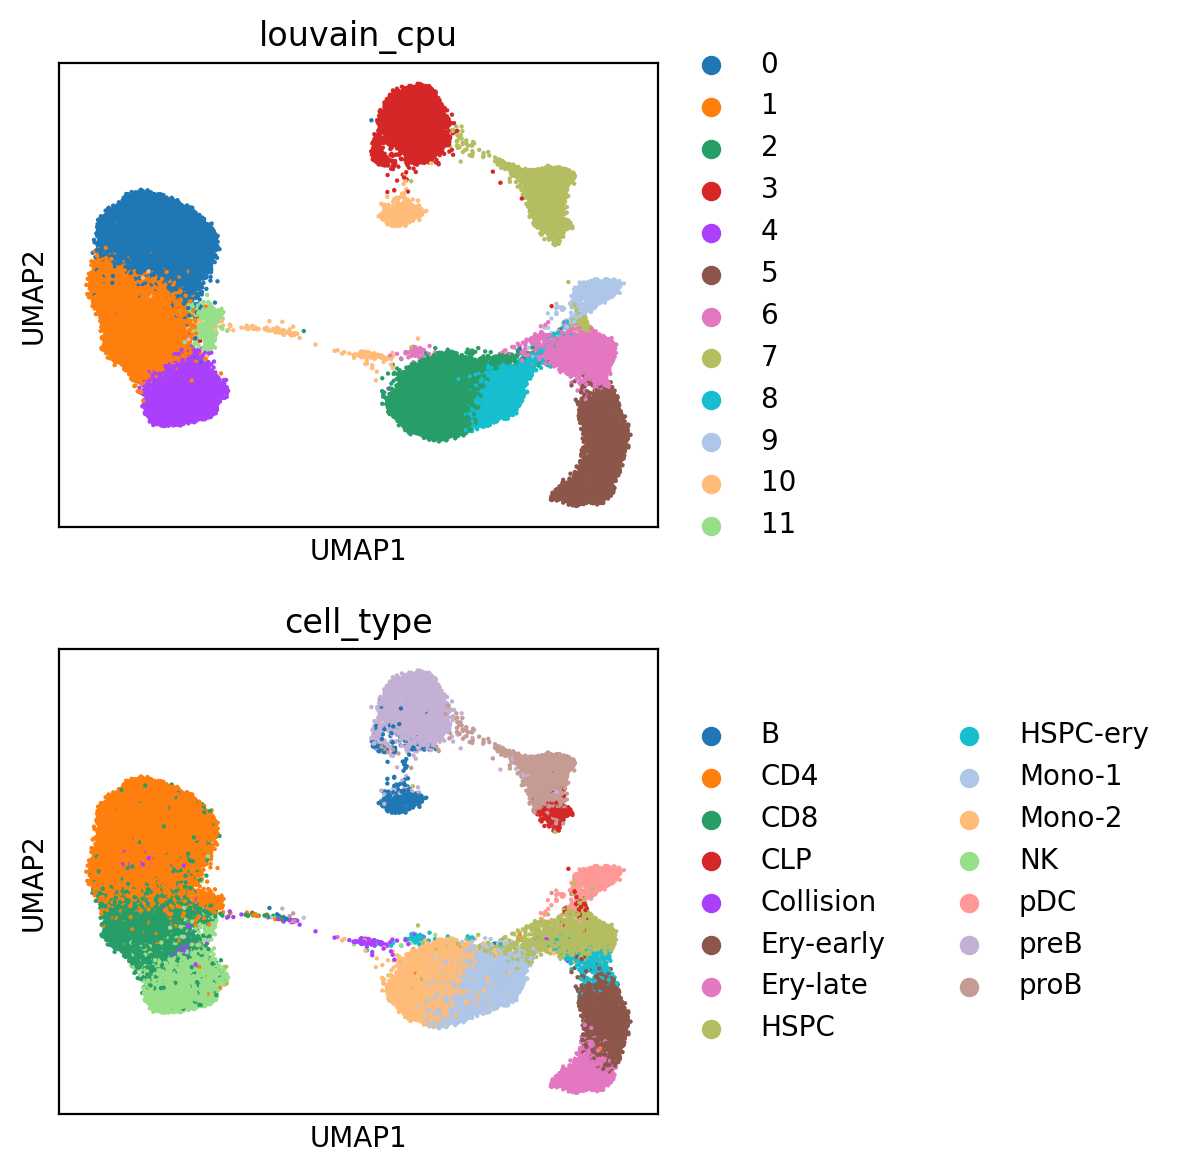

CPU times: user 1.37 s, sys: 237 ms, total: 1.61 s
Wall time: 1.37 s


In [14]:
%%time

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=200)

sc.pl.umap(adata, color=['louvain_cpu'], s=10, ax=ax1, show=False)
sc.pl.umap(adata, color=['cell_type'], s=10, ax=ax2, show=False)
plt.tight_layout()
plt.show()

### tSNE visualization

In [15]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 20min 14s, sys: 0 ns, total: 20min 14s
Wall time: 4min 12s


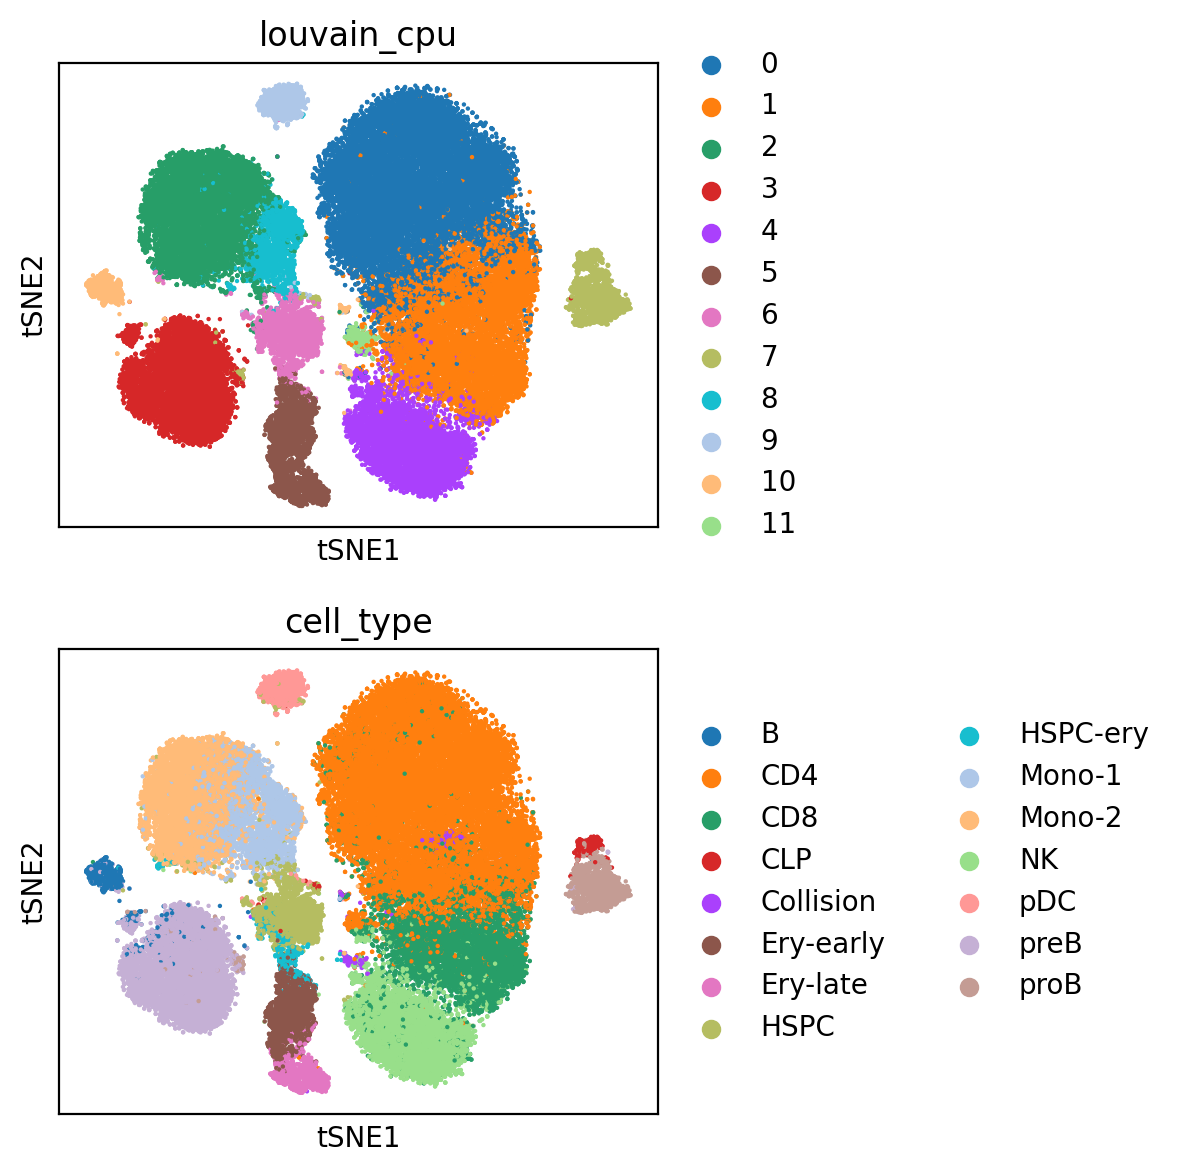

CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.18 s


In [16]:
%%time

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=200)

sc.pl.tsne(adata, color=['louvain_cpu'], s=10, ax=ax1, show=False)
sc.pl.tsne(adata, color=['cell_type'], s=10, ax=ax2, show=False)
plt.tight_layout()
plt.show()

### Marker genes

We use the raw adata object to compute gene activity scores. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [17]:
%%time
# find which peaks overlap with each marker gene
peaks_per_gene = {gene : [] for gene in genes}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in genes:
        if utils.overlap(genes[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")
    
cell_gene_scores = np.zeros((adata.X.shape[0], len(genes.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1)

for (i, gene) in enumerate(genes.keys()):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

MS4A1 has 2 nearby peaks
CD3D has 7 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
LYZ has 1 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.28 s


/raj-test/rapidsgenomics-2/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log2


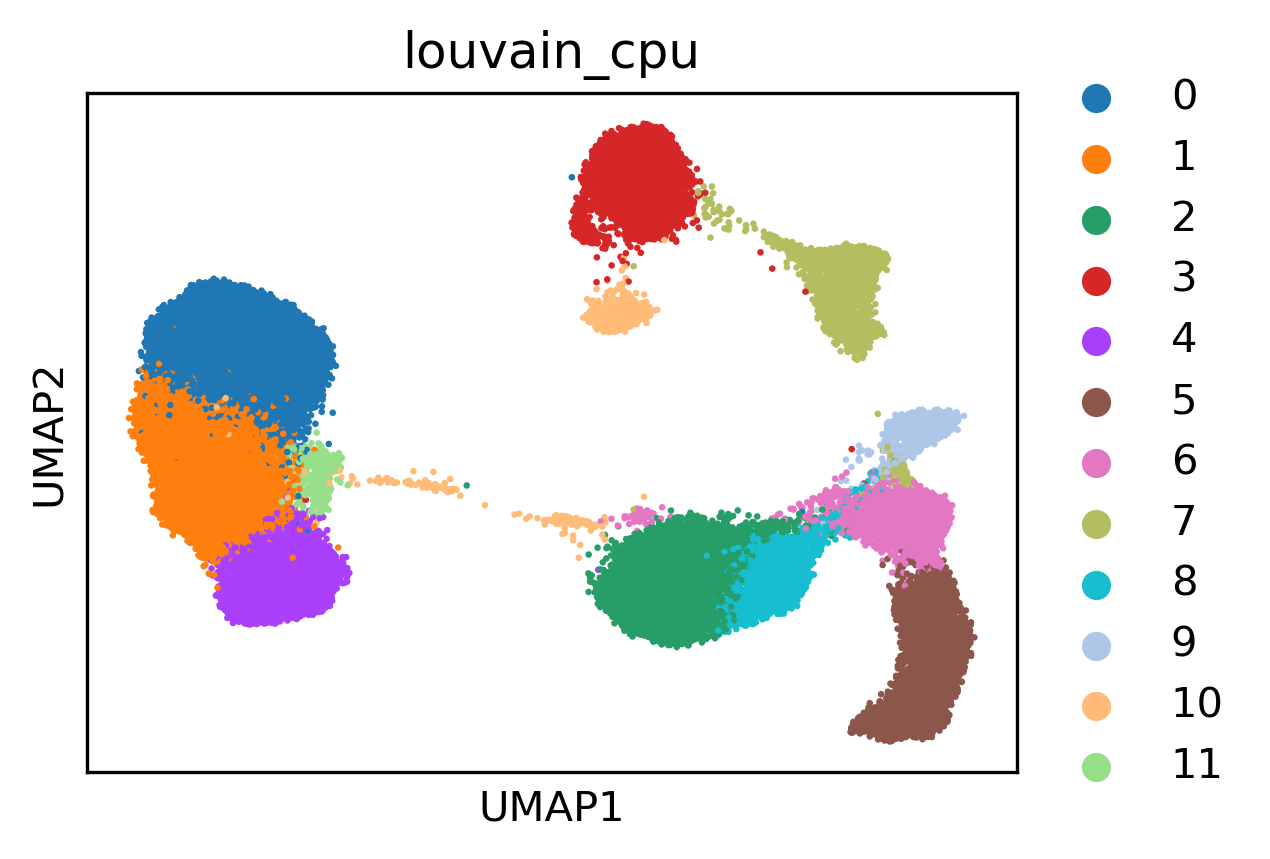

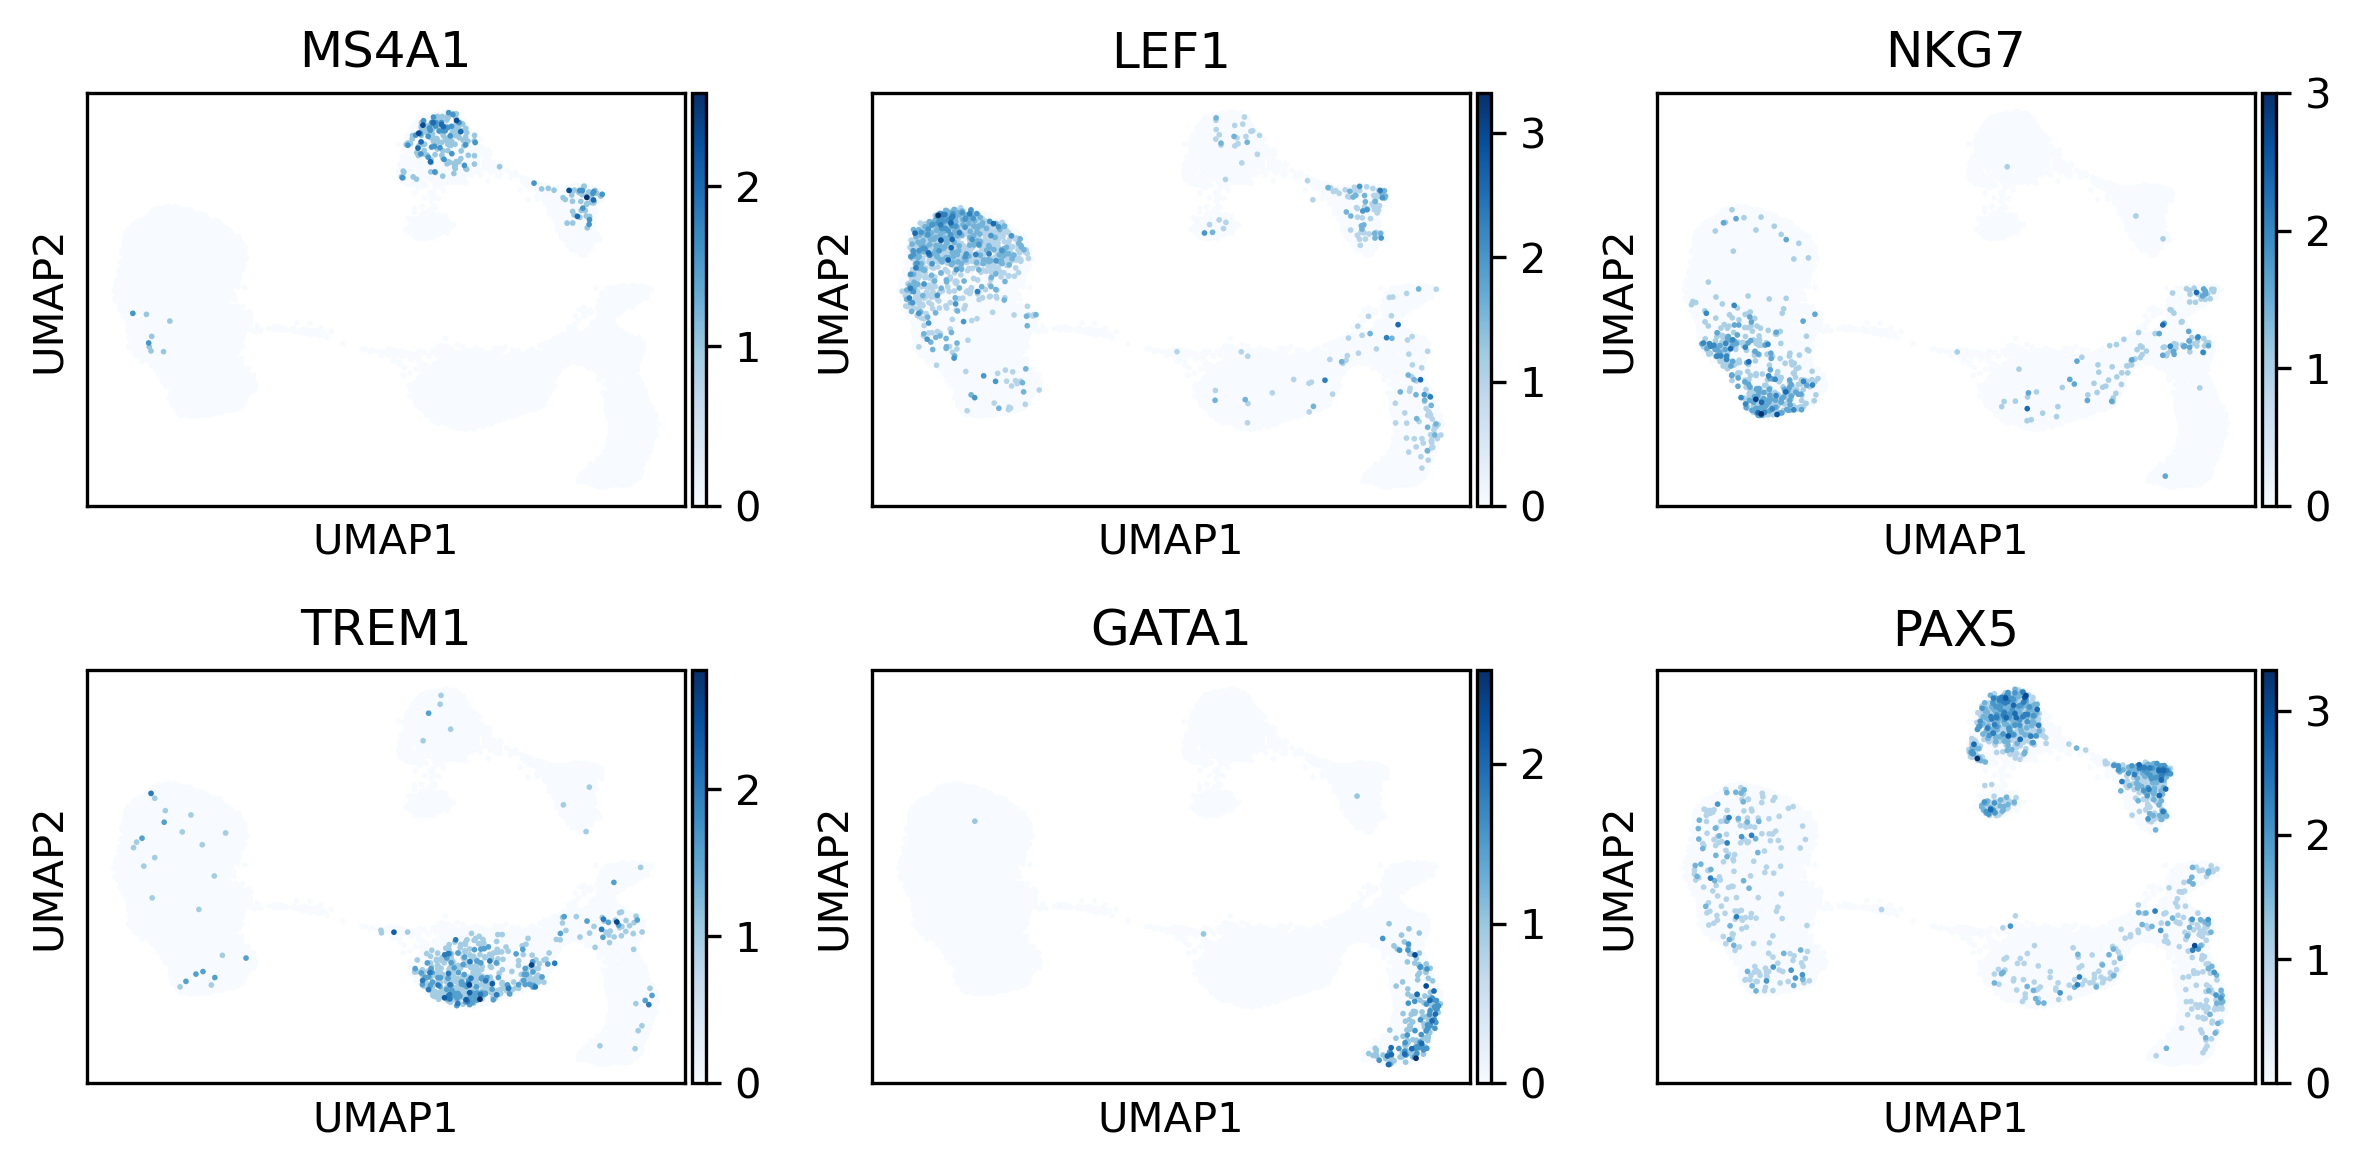

CPU times: user 3.5 s, sys: 0 ns, total: 3.5 s
Wall time: 3.25 s


In [18]:
%%time

plt.figure(figsize=(4,3), dpi=300)
sc.pl.umap(adata, color=['louvain_cpu'], s=10, ax=plt.gca(), show=True)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=300)
axs = axs.flatten()
for (i, gene) in enumerate(genes_to_plot):
    sc.pl.umap(adata, color_map="Blues", s=7.5, color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

In [19]:
%%time
sc.tl.rank_genes_groups(adata, 
                        groupby="louvain_cpu", 
                        n_genes=n_diff_peaks, 
                        groups='all', 
                        reference='rest',
                        method='logreg'
                       )

CPU times: user 3min 21s, sys: 15min 55s, total: 19min 16s
Wall time: 3min 23s


/raj-test/rapidsgenomics-2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


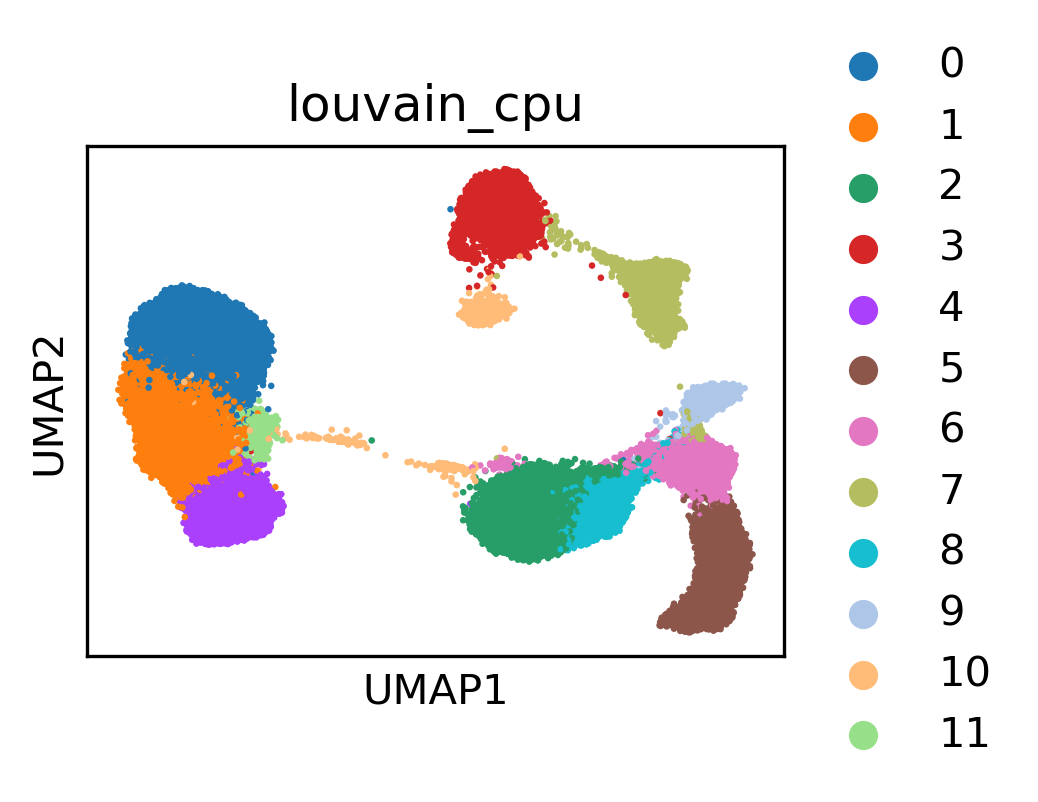

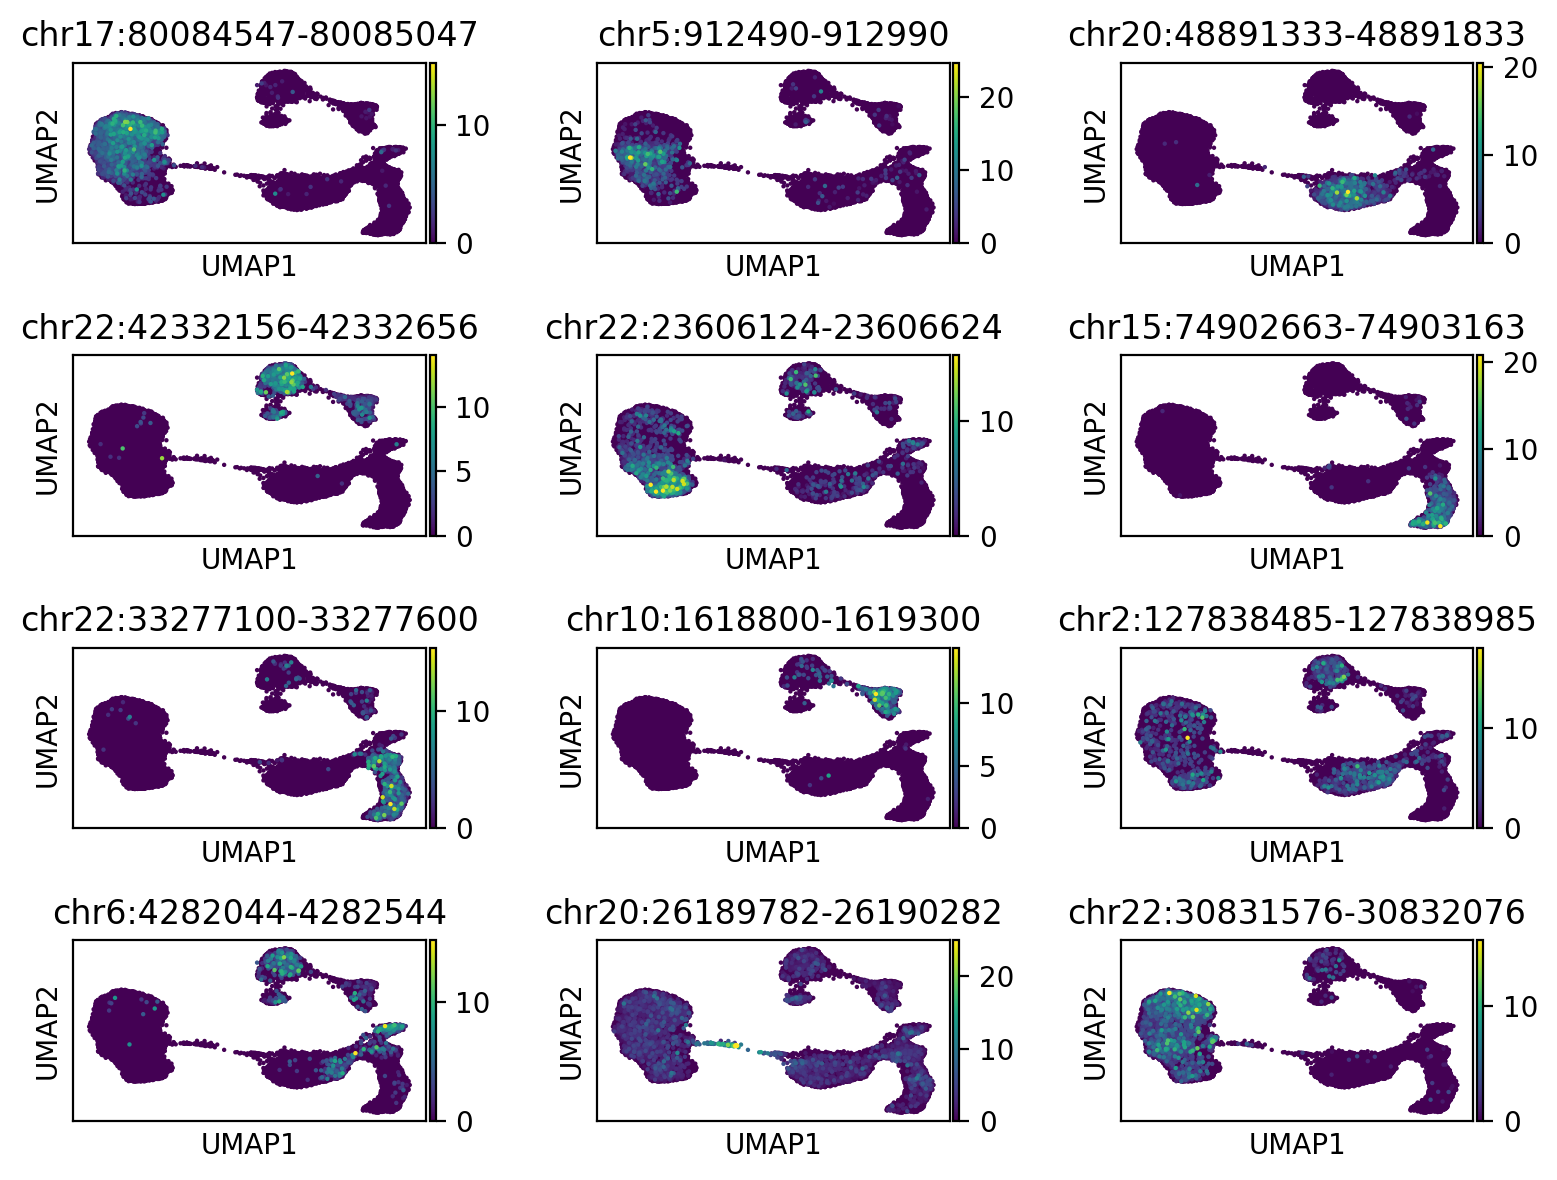

CPU times: user 6.46 s, sys: 144 ms, total: 6.61 s
Wall time: 6.35 s


In [20]:
%%time

fig = plt.figure(figsize=(3,2.25), dpi=300)
ax = plt.gca()

sc.pl.umap(adata, color=['louvain_cpu'], ax=ax, s=10)

# enough subplots to cover all clusters
fig, axs = plt.subplots(len(adata.uns['rank_genes_groups']['names'][0])//3 + 1, 
                        3, figsize=(8,6), dpi=200)
axs = axs.flatten()

for (i, peak) in enumerate(adata.uns['rank_genes_groups']['names'][0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], s=10, show=False,
           vmax=min(25, np.max(adata[:,peak].X)),
           cmap='viridis'
          )
plt.tight_layout()
plt.show()

In [21]:
print("Full time: %s" % (time.time() - start_time))

Full time: 962.3460595607758
